In [1]:
import numpy as np
import pandas as pd
import random
from math import sqrt
import matplotlib.pyplot as plt

In [2]:
class MASS:
    def __init__(self, ant_count=51, q=100, alpha=1, beta=3, rho=0.98, itr=2000,
                 fdc=40, p_best=0.005, delta=0.5, pts=300):
        
        self.ant_count = ant_count      # 蚂蚁数量 | 建议和城市数相同
        self.q = q                      # 更新信息素所用参数 | 即 1/f(s^opt)中的 1/f(x)
        self.alpha = alpha              
        self.beta = beta

        self.itr = itr                  # 循环次数
        self.Shortest = float('inf')    # 最短路径
        self.BestTour = []              # 最短旅程
        self.ant_list = []              
        
        self.fdc = fdc                  # FDC Analysis | 查找离目前城市最近的多少个城市 | 来决定是否使用概率选择城市
        self.rho = rho                  # 1-rho 即政法系数
        self.tau_max = 99999            # 最大信息素值
        self.tau_min = 0                # 最小信息素值
        self.p_best = p_best            # 用于计算最小信息素值
        
        # PTS步骤用的参数
        self.delta = delta              # PTS参数
        self.pts = pts                  # 当MASS循环pts次最佳结果没改变, 则启用一次PTS
        self.pts_count = 0              # 用于计数多少次最佳结果没改变
  
    
    
    def ReadCityInfo(self, fileName):
        
        # 返回N/x/y的df | 第N个城市的坐标为(x,y)
        city_info = pd.read_csv(fileName,
                                sep=' ',
                                skiprows=6, skipfooter=1,
                                engine='python',
                                header=None,
                                names=('N', 'x', 'y'))
        
        # 城市数量
        self.city_count = city_info.shape[0]
        
        # 初始化城市间距离
        self.city_distance = np.zeros(
            (self.city_count, self.city_count))
        
        # 根据tau_max初始化路径间信息素
        self.pheromone = [
            [self.tau_max] * self.city_count for i in range(self.city_count)]

        # 计算城市间距离 | 设置一个节点到自己的信息素为0
        for row in city_info.index:
            for col in city_info.index:
                if row != col:
                    distance = sqrt(pow(city_info.x[row] - city_info.x[col], 2) + pow(city_info.y[row] - city_info.y[col], 2))
                    self.city_distance[row][col] = distance  # 可用[row, col]索引
                else:
                    self.pheromone[row][col] = 0
                    
        # 一个城市到其他城市的距离从小到大排序的索引 | 用于FDC
        self.city_nearest = self.city_distance.argsort()  
        
        # 改变城市间距离形式至列表
        self.city_distance = self.city_distance.tolist()
        
        # 城市个数为N时, 则为[0,1,2,...,N-1]
        self.city_list = city_info.index
        
        # 用于画图
        self.city_info = city_info
        
        
        
        
    def UpdatePheromoneTrail(self, mode):
        
        if mode == 'gb':
            ant = self.global_best_ant
        if mode == 'ib':
            ant = self.itr_best_ant
        pheromone_new = self.q / ant.curr_len
        tour = ant.tabu_city_list
        citys = self.city_list
        
        # 信息素蒸发
        for c1 in citys:
            for c2 in citys:
                if c1 != c2:
                    self.pheromone[c1][c2] *= self.rho
        
        # 信息素更新
        for ind1, ind2 in zip(tour[:-1], tour[1:]):
            self.pheromone[ind1][ind2] += pheromone_new
            self.pheromone[ind2][ind1] += pheromone_new
        
        # 最大最小信息素
        self.tau_max = (1 / (1 - self.rho)) * pheromone_new
        self.tau_min = (self.tau_max * (1 - pow(self.p_best, 1 / self.city_count))) / (((self.city_count / 2) - 1) * pow(self.p_best, 1 / self.city_count))
        for c1 in citys:
            for c2 in citys:
                if c1 != c2:
                    if self.pheromone[c1][c2] > self.tau_max:
                        self.pheromone[c1][c2] = self.tau_max
                    if self.pheromone[c1][c2] < self.tau_min:
                        self.pheromone[c1][c2] = self.tau_min
        
                        
                    
                    
    def PutAnts(self):
        self.ant_list.clear()
        for antNum in range(self.ant_count):
            init_city = random.choice(self.city_list)
            ant = ANT(init_city, self.city_list,
                      self.city_distance, self.pheromone,
                      self.city_nearest, self.fdc)
            self.ant_list.append(ant)    
            
            
            
            
    def Search(self):
        self.global_best_ant = None
        pts_best = float('inf')
        
        for i in range(self.itr):
            self.itr_best_ant = None
            itr_best_len = float('inf')
            
            self.PutAnts()
            for ant in self.ant_list:
                for _ in range(self.city_count):
                    ant.MoveToNextCity(self.alpha, self.beta, self.fdc)
                ant.TwoOptSearch()
                ant.UpdatePathLen()
                if ant.curr_len < itr_best_len:
                    self.itr_best_ant = ant
                    itr_best_len = ant.curr_len
                    
            if itr_best_len < self.Shortest:
                self.global_best_ant = self.itr_best_ant
                self.Shortest = self.itr_best_ant.curr_len
                self.BestTour = self.itr_best_ant.tabu_city_list
            
            # 每十次用global_best更新一次信息素 | 可变更
            if i % 10 == 0:
                mode = 'gb'
            else:
                mode = 'ib'
            self.UpdatePheromoneTrail(mode)
            
            
            # 假设pts次最佳结果没有更新, 则启用一次PTS | 理论上应该放UpdatePheromoneTrail里面, 懒得改了
            if pts_best == self.Shortest:
                self.pts_count += 1
                if self.pts_count == self.pts:
                    self.pts_count = 0
                    for c1 in self.city_list:
                        for c2 in self.city_list:
                            if c1 != c2:
                                self.pheromone[c1][c2] += self.delta * (self.tau_max - self.pheromone[c1][c2])
            else:
                pts_best = self.Shortest
                self.pts_count = 0
            
            
            
            
            
            # 每100次循环输出一次目前最佳结果
            if i % 100 == 0:
                print ('The {}th time best distance is {}'.format(i, self.Shortest))  

    
    
    def draw_tour(self):
        for ind1, ind2 in zip(self.global_best_ant.tabu_city_list[:-1], self.global_best_ant.tabu_city_list[1:]):
            plt.plot([self.city_info.x[ind1], self.city_info.x[ind2]], [self.city_info.y[ind1], self.city_info.y[ind2]], c = 'grey')
            plt.scatter([self.city_info.x[ind1], self.city_info.x[ind2]], [self.city_info.y[ind1], self.city_info.y[ind2]], c = 'red')

In [3]:
class ANT:
    def __init__(self, init_city=None, citys=None, city_distance=None, pheromo=None, cityNear=None, fdc=None):
        
        self.init_city = init_city
        self.tabu_city_list = [init_city, ]
        self.allow_city_set = set(citys)
        self.allow_city_set.remove(init_city)
        self.city_distance = city_distance
        self.pheromone = pheromo
        self.city_nearest = cityNear
        self.transfer_prob_list = []
        self.curr_city = init_city
        self.curr_len = 0
        
        
        self.fdc = fdc

        
        
        
    def SelectNextCity(self, alpha, beta, fdc):

        if len(self.allow_city_set) == 0:
            return self.init_city
        near = self.city_nearest[self.curr_city]
        ANset = self.allow_city_set & set(near[1:fdc]) # 可供行走的城市 交 离目前所在城市最近的fdc个城市 | 这步去掉对结果影响？
        if ANset: # 假设这样的城市存在, 则对所有的城市进行一次概率计算
            sum_prob = 0
            self.transfer_prob_list = []
            for city in self.allow_city_set:
                sum_prob = sum_prob + (
                    pow(self.pheromone[self.curr_city][city], alpha) *
                    pow(1.0 /
                        self.city_distance[self.curr_city][city], beta)
                )
                transfer_prob = sum_prob
                self.transfer_prob_list.append(
                    (city, transfer_prob))
            threshold = sum_prob * random.random()
            for city_ind, city_prob in self.transfer_prob_list:
                if threshold <= city_prob:
                    return (city_ind)
        else:    # 如果最近的fdc个城市不在可供行走的城市里, 则在之后的城市里面, 找一个离现在城市最近的且在可供行走的城市里的当做下一个城市
            for city in near[1:]:
                if city in self.allow_city_set:
                    return city

                
                
    def MoveToNextCity(self, alpha, beta, fdc):
        '''
        对于有0返回值的if语句不能使用if x: ... 判断
        '''
        next_city = self.SelectNextCity(alpha, beta, fdc)
        self.curr_city = next_city
        self.tabu_city_list.append(next_city)
        self.allow_city_set -= set([next_city])

            
            
    def UpdatePathLen(self):
        for city, next_city in zip(self.tabu_city_list[:-1],
                                  self.tabu_city_list[1:]):
            self.curr_len = self.curr_len + self.city_distance[city][next_city]

        
        
        
        
        
    def TwoOptSearch(self):
        '''
        1-2-3-4, 1-2 + 3-4 > 1-3 + 2-4 则交换
        '''
        city_num = len(self.tabu_city_list)
        
        best_improve = 0
        record = None
        
        for i in range(city_num):
            for j in range(city_num - 1, i, -1):
                if j - i >= 3:
                    if city_num - i >= 4:
                        
                        pre_city1 = self.tabu_city_list[i]
                        pre_city2 = self.tabu_city_list[i + 1]
                        fol_city1 = self.tabu_city_list[j]
                        fol_city2 = self.tabu_city_list[j - 1]
                        
                        new_len = self.city_distance[pre_city1][fol_city2] + self.city_distance[pre_city2][fol_city1]
                        old_len = self.city_distance[pre_city1][pre_city2] + self.city_distance[fol_city2][fol_city1]
                        
                        if old_len - new_len > best_improve:
                            record = (i,j)
                            best_improve = old_len - new_len
                            
        if record:               
            i,j = record
            self.tabu_city_list[i+1:j] = self.tabu_city_list[j-1:i:-1]
                        
                        
                        

In [4]:
aco = MASS()

In [5]:
aco.ReadCityInfo('eil51.tsp')

In [6]:
aco.Search()

The 0th time best distance is 646.5943817039912
The 100th time best distance is 498.043790422388
The 200th time best distance is 455.9175149126286
The 300th time best distance is 430.3956561252583
The 400th time best distance is 429.53028334169977
The 500th time best distance is 429.53028334169977
The 600th time best distance is 429.53028334169977
The 700th time best distance is 429.53028334169977
The 800th time best distance is 429.53028334169977
The 900th time best distance is 429.53028334169977
The 1000th time best distance is 429.53028334169977
The 1100th time best distance is 429.53028334169977
The 1200th time best distance is 429.53028334169977
The 1300th time best distance is 428.87175639203394
The 1400th time best distance is 428.87175639203394
The 1500th time best distance is 428.87175639203394
The 1600th time best distance is 428.87175639203394
The 1700th time best distance is 428.87175639203394
The 1800th time best distance is 428.87175639203394
The 1900th time best distance

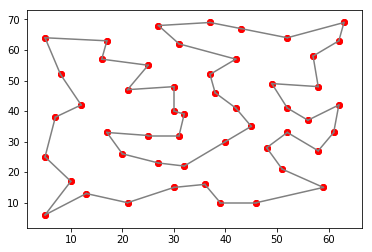

In [7]:
aco.draw_tour()

**参数设置:**
- 每pts=1000次结果没有进步跑一次$\delta=0.7$的PTS
- 每十次用一次global_best更新信息素, 其他时候都用iteration_best更新 |  没有体现在参数里
- FDC=40 | 最近的40个城市里在可行城市列表里, 则通过概率选择下一个去的城市 |  不在列表里则直接选最近的城市
- $\rho=0.98$ |   $1-\rho$即蒸发系数
- $\alpha=1$  $\beta=3$ |  计算下一个走的城市的概率所用系数

目前eil51.tsp的最优解为426
我所用的蚁群算法一般会在前500-600次, 在427-428之间停滞住。
理论上运气好的话能搜索到最优解